In [33]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt

from io import BytesIO

ECB Yield Curve Data 

ECB yield curve data is available from the European central bank as detailed at the following url: 
https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html
The data is available in csv and xml format

In [2]:
# Download ECB yield curve data
ecb_yield_curve_url = 'https://data-api.ecb.europa.eu/service/data/YC/B.U2.EUR.4F.G_N_A.SV_C_YM.?startPeriod=2004-09-06&endPeriod=2023-12-31&format=csvdata'
response = requests.get(ecb_yield_curve_url)

# Open response content in pandas dataframe
ecb_yield_curve_raw_data = pd.read_csv(BytesIO(response.content))

In [16]:
# Display data types in sample
set([(title.split('_')[0]) for title in ecb_yield_curve_raw_data.DATA_TYPE_FM.drop_duplicates().sort_values()])

{'BETA0', 'BETA1', 'BETA2', 'BETA3', 'IF', 'PY', 'SR', 'SRS', 'TAU1', 'TAU2'}

In [18]:
# Generate a dictionary of tenor lengths
tenor_dict = {f'{x}M': x/12 for x in range(1, 12)}
tenor_dict.update({f'{x}Y': x for x in range(1, 31)})
tenor_dict.update({f'{x}Y{y}M': x + y/12 for x in range(1, 31) for y in range(1, 12)})

# Tenor dict subset
tenor_dict_subset = {f'{x}M': x/12 for x in range(1, 12)}
tenor_dict_subset.update({f'{x}Y': x for x in range(1, 10)})
tenor_dict_subset.update({f'{x}Y': x for x in [12,15,20,25,30]})

In [109]:
# Calculate unique values in the dataset
ecb_par_rate = ecb_yield_curve_raw_data[ecb_yield_curve_raw_data.DATA_TYPE_FM.str[:2]=='PY'].pivot(index='TIME_PERIOD', columns='DATA_TYPE_FM', values='OBS_VALUE')
ecb_fwd_rate = ecb_yield_curve_raw_data[ecb_yield_curve_raw_data.DATA_TYPE_FM.str[:2]=='IF'].pivot(index='TIME_PERIOD', columns='DATA_TYPE_FM', values='OBS_VALUE')
ecb_spot_rate = ecb_yield_curve_raw_data[ecb_yield_curve_raw_data.DATA_TYPE_FM.str[:2]=='SR'].pivot(index='TIME_PERIOD', columns='DATA_TYPE_FM', values='OBS_VALUE')

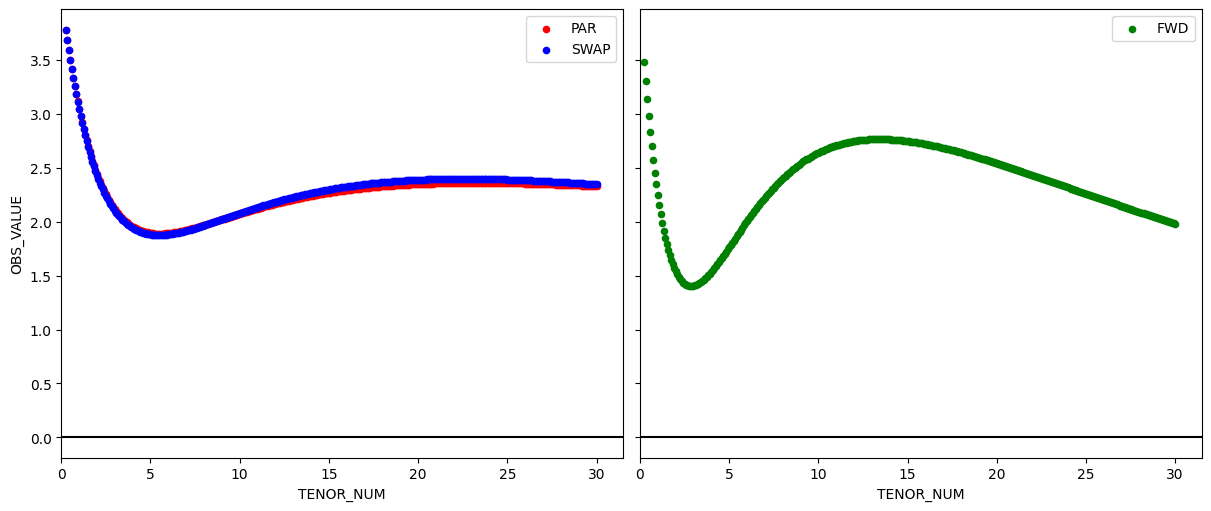

In [110]:
curve_date = np.max(ecb_yield_curve_raw_data.TIME_PERIOD)

ecb_curve_single_day_full = ecb_yield_curve_raw_data[ecb_yield_curve_raw_data.TIME_PERIOD == curve_date].dropna(axis=1)
ecb_curve_single_day = ecb_curve_single_day_full[ecb_curve_single_day_full.columns[(ecb_curve_single_day_full.nunique()!=1)]].copy()
ecb_curve_single_day['CURVE_TYPE'] =ecb_curve_single_day.DATA_TYPE_FM.str.split('_').str[0]
ecb_curve_single_day['TENOR'] =ecb_curve_single_day.DATA_TYPE_FM.str.split('_').str[-1]
ecb_curve_single_day['TENOR_NUM'] = ecb_curve_single_day['TENOR'].replace(tenor_dict)

fig, (ax1, ax2) = plt.subplots(1,2, constrained_layout=True, sharey=True, sharex=True, figsize=(12,5))

# Plot par yields with swap rates
ecb_curve_single_day[(ecb_curve_single_day.CURVE_TYPE=='PY')].sort_values('TENOR_NUM').plot.scatter('TENOR_NUM','OBS_VALUE', ax=ax1, label='PAR', color='r')
ecb_curve_single_day[(ecb_curve_single_day.CURVE_TYPE=='SR')].sort_values('TENOR_NUM').plot.scatter('TENOR_NUM','OBS_VALUE', ax=ax1, label='SWAP', color='b')

# Plot forward rates
ecb_curve_single_day[(ecb_curve_single_day.CURVE_TYPE=='IF')].sort_values('TENOR_NUM').plot.scatter('TENOR_NUM','OBS_VALUE', ax=ax2, label='FWD', color='g')
# Set ax1 range
ax1.set_xlim(0)
ax1.axhline(0, color='black')
ax2.axhline(0, color='black')

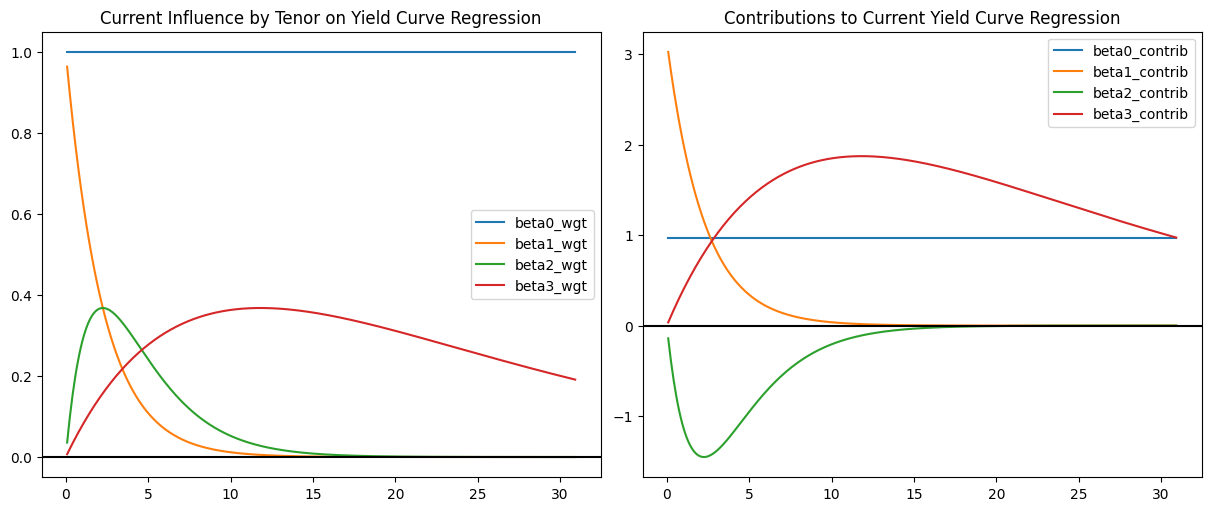

In [111]:
### Visualising the ECB regression parameters for the yield curve
beta0 = ecb_curve_single_day.set_index('CURVE_TYPE').loc['BETA0', 'OBS_VALUE']
beta1 = ecb_curve_single_day.set_index('CURVE_TYPE').loc['BETA1', 'OBS_VALUE']
beta2 = ecb_curve_single_day.set_index('CURVE_TYPE').loc['BETA2', 'OBS_VALUE']
beta3 = ecb_curve_single_day.set_index('CURVE_TYPE').loc['BETA3', 'OBS_VALUE']

tau1 = ecb_curve_single_day.set_index('CURVE_TYPE').loc['TAU1', 'OBS_VALUE']
tau2 = ecb_curve_single_day.set_index('CURVE_TYPE').loc['TAU2', 'OBS_VALUE']

fig, (ax1, ax2) = plt.subplots(1,2, constrained_layout=True, sharex=True, figsize=(12,5))

# Get ECB curve model regression exhibits
ecb_curve_model = pd.DataFrame(index=tenor_dict.values()).sort_index().copy()
ecb_curve_model['tenor'] = ecb_curve_model.index
ecb_curve_model['beta0_wgt'] = 1
ecb_curve_model['beta1_wgt'] = ecb_curve_model.tenor.apply(lambda x: np.exp(-x/tau1))
ecb_curve_model['beta2_wgt'] = ecb_curve_model.tenor.apply(lambda x: np.exp(-x/tau1)) * ecb_curve_model.tenor / tau1
ecb_curve_model['beta3_wgt'] = ecb_curve_model.tenor.apply(lambda x: np.exp(-x/tau2)) * ecb_curve_model.tenor / tau2
ecb_curve_model[[x for x in ecb_curve_model.columns if '_wgt' in x]].plot(ax=ax1, title='Current Influence by Tenor on Yield Curve Regression')
ax1.axhline(0, color='black')

# Visualising the contributions of each parameter to the yield curve
ecb_curve_model['beta0_contrib'] = ecb_curve_model.beta0_wgt * beta0
ecb_curve_model['beta1_contrib'] = ecb_curve_model.beta1_wgt * beta1
ecb_curve_model['beta2_contrib'] = ecb_curve_model.beta2_wgt * beta2
ecb_curve_model['beta3_contrib'] = ecb_curve_model.beta3_wgt * beta3
ecb_curve_model[[x for x in ecb_curve_model.columns if '_contrib' in x]].plot(ax=ax2, title='Contributions to Current Yield Curve Regression')
ax2.axhline(0, color='black')

DATA_TYPE_FM,PY_10M,PY_10Y,PY_10Y10M,PY_10Y11M,PY_10Y1M,PY_10Y2M,PY_10Y3M,PY_10Y4M,PY_10Y5M,PY_10Y6M,...,PY_9Y11M,PY_9Y1M,PY_9Y2M,PY_9Y3M,PY_9Y4M,PY_9Y5M,PY_9Y6M,PY_9Y7M,PY_9Y8M,PY_9Y9M
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2004-09-06,0.009239,-0.065199,-0.065674,-0.065701,-0.065266,-0.065327,-0.065384,-0.065437,-0.065486,-0.065531,...,-0.065129,-0.064128,-0.064255,-0.064375,-0.064489,-0.064597,-0.064699,-0.064796,-0.064887,-0.064973
2004-09-07,-0.027300,-0.077280,-0.075582,-0.075412,-0.077111,-0.076942,-0.076773,-0.076603,-0.076433,-0.076263,...,-0.077448,-0.079091,-0.078931,-0.078770,-0.078608,-0.078445,-0.078281,-0.078116,-0.077950,-0.077784
2004-09-08,-0.040555,-0.098357,-0.095781,-0.095528,-0.098096,-0.097836,-0.097576,-0.097317,-0.097059,-0.096802,...,-0.098619,-0.101248,-0.100985,-0.100722,-0.100458,-0.100195,-0.099932,-0.099668,-0.099405,-0.099143
2004-09-09,0.001649,-0.030139,-0.030333,-0.030349,-0.030161,-0.030183,-0.030204,-0.030225,-0.030244,-0.030263,...,-0.030116,-0.029833,-0.029866,-0.029898,-0.029928,-0.029958,-0.029987,-0.030014,-0.030041,-0.030067
2004-09-10,0.011573,-0.020285,-0.020670,-0.020704,-0.020328,-0.020370,-0.020411,-0.020451,-0.020489,-0.020527,...,-0.020241,-0.019731,-0.019789,-0.019844,-0.019899,-0.019951,-0.020003,-0.020053,-0.020102,-0.020149
2004-09-13,-0.020471,-0.056394,-0.055955,-0.055914,-0.056348,-0.056301,-0.056256,-0.056211,-0.056166,-0.056123,...,-0.056442,-0.056957,-0.056902,-0.056848,-0.056795,-0.056743,-0.056691,-0.056640,-0.056589,-0.056539


In [115]:
ecb_spot_rate_change.head()

DATA_TYPE_FM,SRS_10Y_1Y,SRS_10Y_2Y,SRS_10Y_3M,SR_10M,SR_10Y,SR_10Y10M,SR_10Y11M,SR_10Y1M,SR_10Y2M,SR_10Y3M,...,SR_9Y11M,SR_9Y1M,SR_9Y2M,SR_9Y3M,SR_9Y4M,SR_9Y5M,SR_9Y6M,SR_9Y7M,SR_9Y8M,SR_9Y9M
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2004-09-06,-0.078602,-0.066366,-0.077445,0.009228,-0.070255,-0.070851,-0.070886,-0.070337,-0.070414,-0.070485,...,-0.070167,-0.068943,-0.069097,-0.069243,-0.069381,-0.069513,-0.069638,-0.069756,-0.069868,-0.069974
2004-09-07,-0.045946,-0.020924,-0.075985,-0.027363,-0.078976,-0.077018,-0.076819,-0.078783,-0.078590,-0.078396,...,-0.079167,-0.081010,-0.080833,-0.080654,-0.080474,-0.080291,-0.080107,-0.079922,-0.079735,-0.079547
2004-09-08,-0.050692,-0.015877,-0.096171,-0.040652,-0.099672,-0.096689,-0.096393,-0.099373,-0.099073,-0.098774,...,-0.099971,-0.102946,-0.102652,-0.102356,-0.102060,-0.101763,-0.101465,-0.101167,-0.100868,-0.100570
2004-09-09,-0.031165,-0.020407,-0.042446,0.001607,-0.031799,-0.032077,-0.032101,-0.031831,-0.031861,-0.031891,...,-0.031767,-0.031388,-0.031431,-0.031473,-0.031513,-0.031553,-0.031591,-0.031628,-0.031664,-0.031700
2004-09-10,-0.032195,-0.023993,-0.037654,0.011537,-0.022006,-0.022488,-0.022530,-0.022059,-0.022111,-0.022162,...,-0.021952,-0.021331,-0.021400,-0.021468,-0.021533,-0.021597,-0.021660,-0.021721,-0.021781,-0.021839


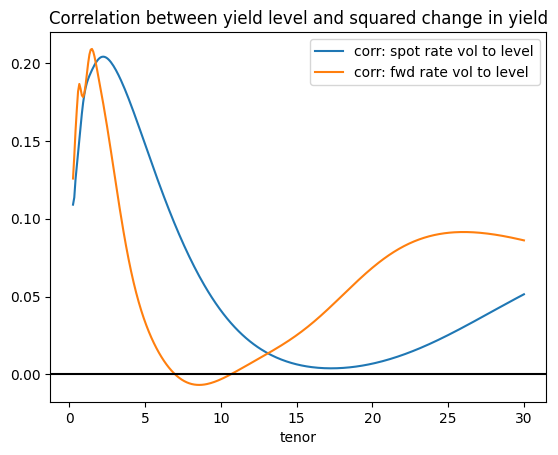

In [118]:
period_length = 5

# Calculate curve changes
ecb_par_rate_change = - ecb_par_rate.diff(periods=-period_length)
ecb_fwd_rate_change = - ecb_fwd_rate.diff(periods=-period_length)
ecb_spot_rate_change = - ecb_spot_rate.diff(periods=-period_length)

# Regress squared level changes against level
ecb_rate_vol_regression = pd.DataFrame({'tenor':tenor_dict})
ecb_rate_vol_regression['corr: change to level'] = None
ecb_rate_vol_regression['corr: vol to level'] = None

for tenor in ecb_rate_vol_regression.index:
    try:
        spot_rate_tenor = f'SR_{tenor}'
        ecb_rate_vol_regression.loc[tenor, 'corr: spot rate vol to level'] = (ecb_spot_rate_change[spot_rate_tenor]**2).corr(ecb_spot_rate[spot_rate_tenor])
    except:
        pass
    try:
        fwd_rate_tenor = f'IF_{tenor}'
        ecb_rate_vol_regression.loc[tenor, 'corr: fwd rate vol to level'] = (ecb_fwd_rate_change[fwd_rate_tenor]**2).corr(ecb_fwd_rate[fwd_rate_tenor])
    except:
        pass
    
fig, ax = plt.subplots()
ecb_rate_vol_regression.sort_values('tenor').plot(x='tenor', y=[x for x in ecb_rate_vol_regression.columns if 'corr' in x], title='Correlation between yield level and squared change in yield', ax=ax)
ax.axhline(0, color='black')

[]

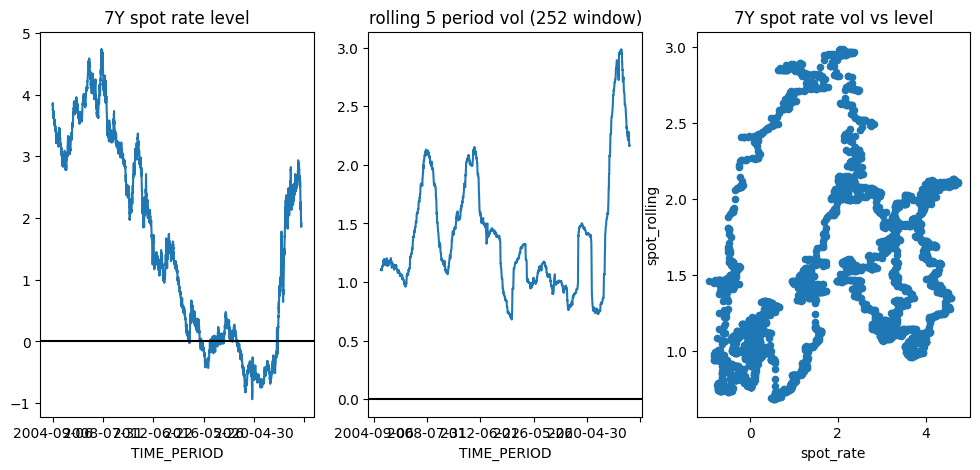

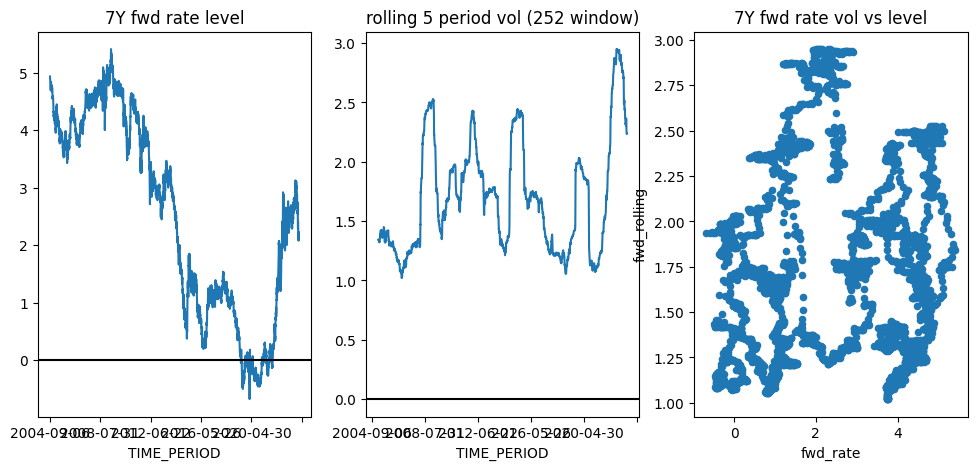

In [142]:
tenor = '7Y'
period_length = 5
rolling_length = 252

single_tenor_ts = ecb_yield_curve_raw_data[ecb_yield_curve_raw_data.DATA_TYPE_FM.str[-len(tenor)-1:]== f'_{tenor}'].pivot(index='TIME_PERIOD', columns='DATA_TYPE_FM', values='OBS_VALUE')[[f'IF_{tenor}', f'SR_{tenor}']].dropna()
single_tenor_ts.rename({f'IF_{tenor}': 'fwd_rate', f'SR_{tenor}':'spot_rate'}, axis=1, inplace=True)
single_tenor_ts['fwd_change'] = - single_tenor_ts.fwd_rate.diff(periods=-period_length)
single_tenor_ts['fwd_vol'] = single_tenor_ts.fwd_change**2
single_tenor_ts['fwd_rolling'] = single_tenor_ts.fwd_change.rolling(rolling_length).std().shift(int(-rolling_length/2)) * 252 ** 0.5

single_tenor_ts['spot_change'] = - single_tenor_ts.spot_rate.diff(periods=-period_length)
single_tenor_ts['spot_vol'] = single_tenor_ts.spot_change**2
single_tenor_ts['spot_rolling'] = single_tenor_ts.spot_change.rolling(rolling_length).std().shift(int(-rolling_length/2)) * 252 ** 0.5

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,5))
single_tenor_ts.spot_rate.plot(ax=ax1, title=f'{tenor} spot rate level')
ax1.axhline(0, color='black')
single_tenor_ts.spot_rolling.plot(ax=ax2, title=f'rolling {period_length} period vol ({rolling_length} window)')
ax2.axhline(0, color='black')
single_tenor_ts.plot.scatter('spot_rate', 'spot_rolling', ax=ax3, title=f'{tenor} spot rate vol vs level')
plt.plot()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,5))
single_tenor_ts.fwd_rate.plot(ax=ax1, title=f'{tenor} fwd rate level')
ax1.axhline(0, color='black')
single_tenor_ts.fwd_rolling.plot(ax=ax2, title=f'rolling {period_length} period vol ({rolling_length} window)')
ax2.axhline(0, color='black')
single_tenor_ts.plot.scatter('fwd_rate', 'fwd_rolling', ax=ax3, title=f'{tenor} fwd rate vol vs level')
plt.plot()

[]

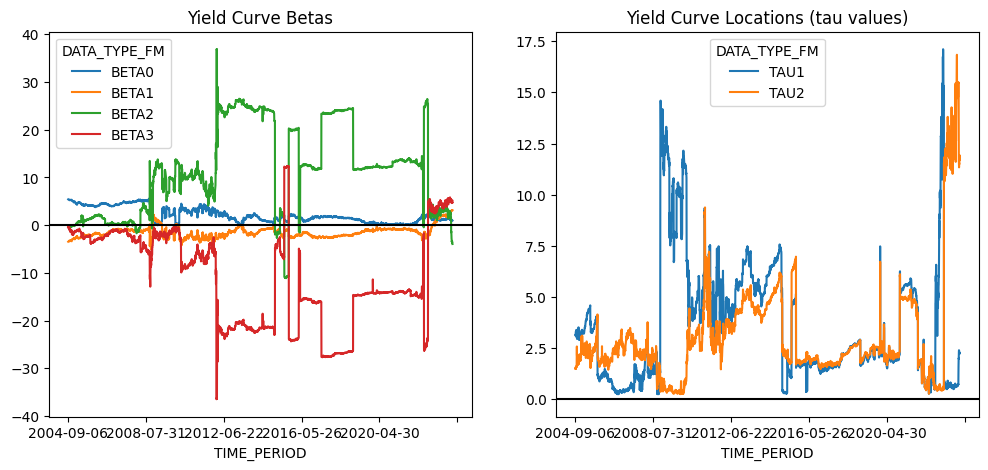

In [146]:
ecb_regression_parameters = ecb_yield_curve_raw_data[ecb_yield_curve_raw_data.DATA_TYPE_FM.str[:3].isin(['BET','TAU'])].pivot(index='TIME_PERIOD', columns='DATA_TYPE_FM', values='OBS_VALUE').copy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ecb_regression_parameters[[x for x in ecb_regression_parameters if 'BETA' in x]].plot(ax=ax1, title=f'Yield Curve Betas')
ax1.axhline(0, color='black')
ecb_regression_parameters[[x for x in ecb_regression_parameters if 'TAU' in x]].plot(ax=ax2, title=f'Yield Curve Locations (tau values)')
ax2.axhline(0, color='black')
plt.plot()